# QMSS5074GR - Final Project (3rd)


### Your Grp ID: [G_12]
### Your UNIs: [sc5570, yz4877, yh3774]
### Your Full Names: [Haley Chen, Yongjun Zhu, Julia Hu]
### Public GitHub Repo: [https://github.com/edyy-Z/Project-of-advanced-machine-learning.git ]

## Part 1 – Data Ingestion & Preprocessing


1. **Data Loading**  
    - Acquire the Stanford Sentiment Treebank dataset.
    - Split into training, validation, and test sets with stratified sampling to preserve class balance.
    - Clearly document your splitting strategy and resulting dataset sizes.
    

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the Stanford Sentiment Treebank v2 (binary classification)
dataset = load_dataset("glue", "sst2")

# Convert to Pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Stratified split: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Train size: 53879, Val size: 6735, Test size: 6735



2. **Text Cleaning & Tokenization**  
    - Implement a reusable preprocessing pipeline that handles at least:  
        - HTML removal, lowercasing, punctuation stripping  
        - Vocabulary pruning (e.g., rare words threshold)  
        - Tokenization (character- or word-level)  
    - Expose this as a function/class so it can be saved and re-loaded for inference.
    

In [ ]:
import re
import string
import pickle
from collections import Counter

class TextPreprocessor:
    def __init__(self, rare_word_thresh=2, level="word"):
        self.rare_word_thresh = rare_word_thresh
        self.level = level  # "word" or "char"
        self.vocab = set()

    def clean(self, text):
        text = re.sub(r'<[^>]*>', '', text)  # Remove HTML
        text = text.lower()
        text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize(self, text):
        if self.level == "word":
            return text.split()
        elif self.level == "char":
            return list(text)
        else:
            raise ValueError("Level must be 'word' or 'char'")

    def fit(self, texts):
        cleaned = [self.clean(text) for text in texts]
        token_lists = [self.tokenize(text) for text in cleaned]
        word_counts = Counter(token for tokens in token_lists for token in tokens)
        self.vocab = {w for w, c in word_counts.items() if c >= self.rare_word_thresh}

    def transform(self, texts):
        cleaned = [self.clean(text) for text in texts]
        return [
            [tok for tok in self.tokenize(text) if tok in self.vocab]
            for text in cleaned
        ]

    def fit_transform(self, texts):
        self.fit(texts)
        return self.transform(texts)

    def save(self, path='text_preprocessor.pkl'):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path='text_preprocessor.pkl'):
        with open(path, 'rb') as f:
            return pickle.load(f)


3. **Feature Extraction**  
    - **Traditional**: Build a TF-IDF vectorizer (or n-gram count) pipeline.  
    - **Neural**: Prepare sequences for embedding—pad/truncate to a fixed length.  
    - Save each preprocessor (vectorizer/tokenizer) to disk.
    

In [ ]:
# Traditional: TF-IDF Vectorizer Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

def build_tfidf_vectorizer(tokenized_texts, ngram_range=(1, 2), max_features=10000):
    joined_texts = [' '.join(tokens) for tokens in tokenized_texts]  # join tokens back into strings
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_tfidf = vectorizer.fit_transform(joined_texts)

    # Save to disk
    with open("tfidf_vectorizer.pkl", "wb") as f:
        pickle.dump(vectorizer, f)

    return vectorizer, X_tfidf

In [ ]:
# Neural: Tokenizer + Sequence Padding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def build_tokenizer(tokenized_texts, num_words=10000):
    texts = [' '.join(tokens) for tokens in tokenized_texts]
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)

    # Save tokenizer
    with open("keras_tokenizer.pkl", "wb") as f:
        pickle.dump(tokenizer, f)

    return tokenizer
def get_padded_sequences(tokenizer, tokenized_texts, maxlen=50):
    texts = [' '.join(tokens) for tokens in tokenized_texts]
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
    return padded


In [ ]:
# Apply everything together using your reusable components

# Initialize preprocessor
preprocessor = TextPreprocessor(rare_word_thresh=2, level="word")

# Preprocess texts
X_train_tok = preprocessor.fit_transform(train_df["sentence"])
X_val_tok = preprocessor.transform(val_df["sentence"])
X_test_tok = preprocessor.transform(test_df["sentence"])

# Labels
y_train = train_df["label"].values
y_val = val_df["label"].values
y_test = test_df["label"].values

# --- TF-IDF ---
tfidf_vectorizer, X_train_tfidf = build_tfidf_vectorizer(X_train_tok)
X_val_tfidf = tfidf_vectorizer.transform([' '.join(t) for t in X_val_tok])
X_test_tfidf = tfidf_vectorizer.transform([' '.join(t) for t in X_test_tok])

# --- Neural Sequences ---
tokenizer = build_tokenizer(X_train_tok)
X_train_pad = get_padded_sequences(tokenizer, X_train_tok)
X_val_pad = get_padded_sequences(tokenizer, X_val_tok)
X_test_pad = get_padded_sequences(tokenizer, X_test_tok)

## Part 2 – Exploratory Data Analysis (EDA)

In [ ]:
!pip install wordcloud seaborn

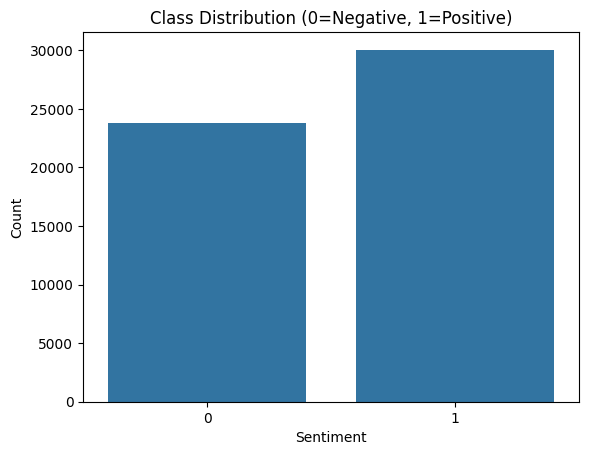

Review Length Statistics:
Mean: 8.63
Median: 6.0
IQR: 9.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import pandas as pd

# Use cleaned & tokenized versions from Part 1
train_df["tokens"] = X_train_tok
train_df["review_len"] = train_df["tokens"].apply(len)


# Class Distribution
# Bar chart of class distribution
sns.countplot(data=train_df, x="label")
plt.title("Class Distribution (0=Negative, 1=Positive)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Descriptive statistics on review length
length_stats = train_df["review_len"].describe()
iqr = length_stats["75%"] - length_stats["25%"]

print("Review Length Statistics:")
print(f"Mean: {length_stats['mean']:.2f}")
print(f"Median: {train_df['review_len'].median()}")
print(f"IQR: {iqr}")

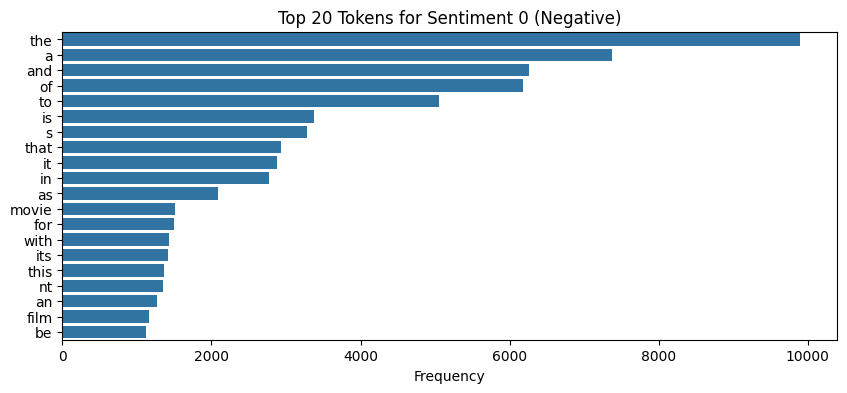

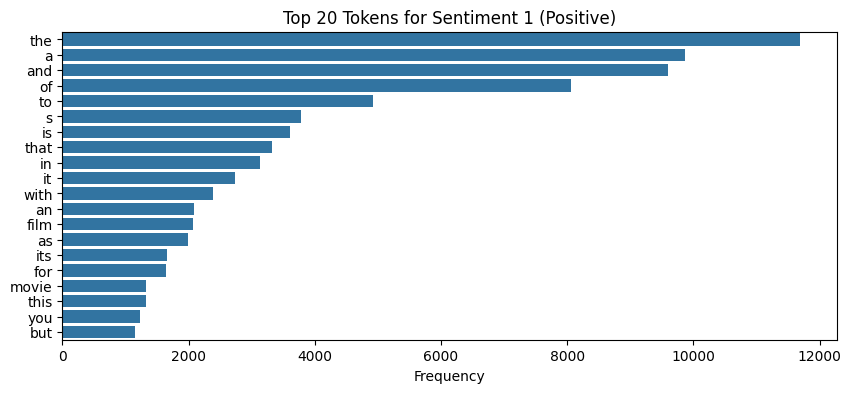

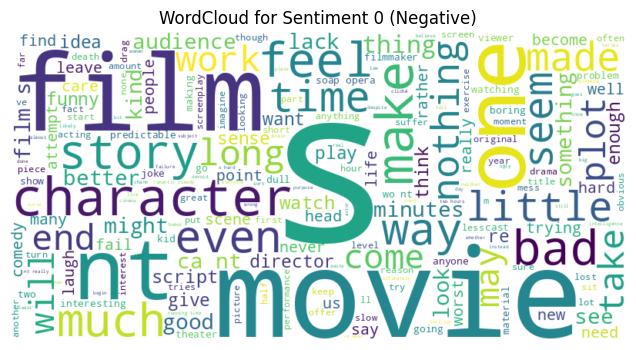

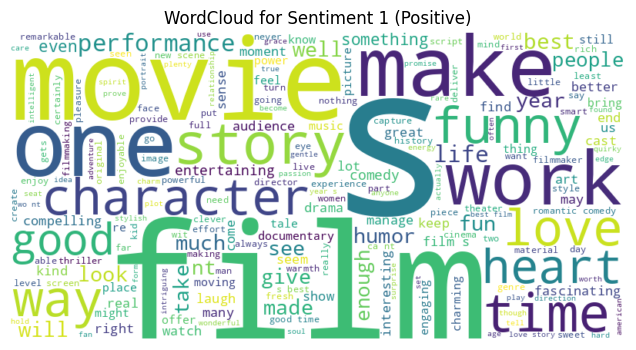

In [ ]:
# this part : Text Characteristics (Top Tokens + Word Clouds)


def top_tokens_by_class(df, label, top_n=20):
    tokens = df[df["label"] == label]["tokens"].sum()
    return Counter(tokens).most_common(top_n)

# Plot top 20 tokens per class
for sentiment in [0, 1]:
    top_words = top_tokens_by_class(train_df, sentiment)
    words, freqs = zip(*top_words)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(freqs), y=list(words))
    plt.title(f"Top 20 Tokens for Sentiment {sentiment} ({'Negative' if sentiment==0 else 'Positive'})")
    plt.xlabel("Frequency")
    plt.show()

# WordClouds
for sentiment in [0, 1]:
    text = " ".join(train_df[train_df["label"] == sentiment]["tokens"].sum())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for Sentiment {sentiment} ({'Negative' if sentiment==0 else 'Positive'})")
    plt.show()

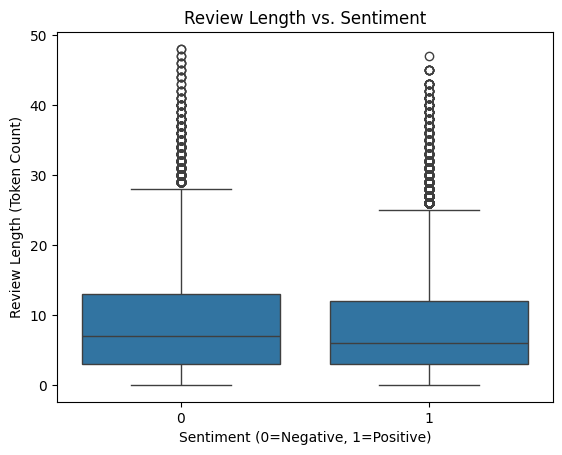

Correlation between review length and sentiment: -0.0548


In [ ]:
# Correlation Analysis: Review Length vs. Sentiment

# Boxplot of review lengths by sentiment
sns.boxplot(data=train_df, x="label", y="review_len")
plt.title("Review Length vs. Sentiment")
plt.xlabel("Sentiment (0=Negative, 1=Positive)")
plt.ylabel("Review Length (Token Count)")
plt.show()

# Correlation Coefficient
correlation = np.corrcoef(train_df["label"], train_df["review_len"])[0, 1]
print(f"Correlation between review length and sentiment: {correlation:.4f}")


## Part 3 – Baseline Traditional Models

In [ ]:
!pip install xgboost

In [ ]:
# Train Linear Models with Cross-Validation



from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import pandas as pd

# Logistic Regression (with C tuning)
log_reg = LogisticRegression(max_iter=1000)
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_tfidf, y_train)

# Linear SVM
svm = LinearSVC(C=1.0, max_iter=10000)
svm.fit(X_train_tfidf, y_train)

LinearSVC(max_iter=10000)

In [ ]:
# Step 3: Train Tree-Based Models
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_tfidf, y_train)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:11:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Evaluation based on Test set

models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Linear SVM': svm,
    'Random Forest': rf,
    'XGBoost': xgb
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred)
    })

df_results = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(df_results)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
1           Linear SVM  0.878990   0.877373  0.910301  0.893534  0.874895
0  Logistic Regression  0.878396   0.875896  0.911099  0.893151  0.874119
2        Random Forest  0.877357   0.894907  0.883950  0.889395  0.876495
3              XGBoost  0.767483   0.722889  0.945701  0.819419  0.744174


In [ ]:
### feature importance : this is for tree only

# Get TF-IDF feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Random Forest Feature Importance
importances_rf = rf.feature_importances_
top_rf = sorted(zip(importances_rf, feature_names), reverse=True)[:10]
print("Top 10 Features (Random Forest):")
for imp, feat in top_rf:
    print(f"{feat}: {imp:.4f}")

# XGBoost Feature Importance
importances_xgb = xgb.feature_importances_
top_xgb = sorted(zip(importances_xgb, feature_names), reverse=True)[:10]
print("\nTop 10 Features (XGBoost):")
for imp, feat in top_xgb:
    print(f"{feat}: {imp:.4f}")

Top 10 Features (Random Forest):
bad: 0.0092
too: 0.0091
and: 0.0089
nt: 0.0076
the: 0.0073
no: 0.0064
of: 0.0055
not: 0.0055
to: 0.0050
good: 0.0043

Top 10 Features (XGBoost):
bad: 0.0104
too: 0.0099
best: 0.0066
plot: 0.0057
nt: 0.0056
dialogue: 0.0056
dull: 0.0055
worst: 0.0055
heart: 0.0051
mess: 0.0048


## Part 4 – Neural Network Models


1. **Simple Feed-Forward**  
    - Build an embedding layer + a dense MLP classifier.  
    - Ensure you freeze vs. unfreeze embeddings in separate runs.
    

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

def build_mlp_model(vocab_size, embedding_dim=50, input_length=50, freeze_embedding=True):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_shape=(input_length,),  # <- FIX HERE
                        trainable=not freeze_embedding))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
    return model

vocab_size = min(10000, len(tokenizer.word_index) + 1)
mlp_model = build_mlp_model(vocab_size=vocab_size, freeze_embedding=True)  # or False
mlp_model.summary()

# Train
mlp_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=5, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       160,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,129 (2.52 MB)

 Trainable params: 160,129 (625.50 KB)

 Non-trainable params: 500,000 (1.91 MB)

Epoch 1/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.5555 - loss: 0.6866 - val_accuracy: 0.5577 - val_loss: 0.6832
Epoch 2/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5592 - loss: 0.6839 - val_accuracy: 0.5648 - val_loss: 0.6811
Epoch 3/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.5656 - loss: 0.6798 - val_accuracy: 0.5740 - val_loss: 0.6778
Epoch 4/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5766 - loss: 0.6759 - val_accuracy: 0.5773 - val_loss: 0.6747
Epoch 5/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5790 - loss: 0.6716 - val_accuracy: 0.5865 - val_loss: 0.6721


2. **Convolutional Text Classifier**  
    - Implement a 1D-CNN architecture (Conv + Pooling) for sequence data.
    - Justify your choice of kernel sizes and number of filters.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout

def build_cnn_model(vocab_size, embedding_dim=50, input_length=50, kernel_sizes=[3, 4, 5], num_filters=100):
    input_layer = Input(shape=(input_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length)(input_layer)

    # Apply multiple convolution filters of different sizes (n-gram detection)
    convs = []
    for k in kernel_sizes:
        conv = Conv1D(filters=num_filters, kernel_size=k, activation='relu')(embedding)
        pool = GlobalMaxPooling1D()(conv)
        convs.append(pool)

    concat = Concatenate()(convs)
    dropout = Dropout(0.5)(concat)
    dense = Dense(64, activation='relu')(dropout)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
    return model

cnn_model = build_cnn_model(vocab_size=vocab_size)
cnn_model.summary()

# Train
cnn_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=5, batch_size=32)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 50, 50)    │    500,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 100)   │     15,100 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 47, 100)   │     20,100 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 46, 100)   │     25,100 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 300)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 300)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     19,264 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 579,629 (2.21 MB)

 Trainable params: 579,629 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 55s 31ms/step - accuracy: 0.7504 - loss: 0.4735 - val_accuracy: 0.8962 - val_loss: 0.2562
Epoch 2/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.9322 - loss: 0.1751 - val_accuracy: 0.9096 - val_loss: 0.2342
Epoch 3/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.9526 - loss: 0.1189 - val_accuracy: 0.9082 - val_loss: 0.2304
Epoch 4/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.9640 - loss: 0.0896 - val_accuracy: 0.9145 - val_loss: 0.2636
Epoch 5/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.9685 - loss: 0.0744 - val_accuracy: 0.9158 - val_loss: 0.3009


Kernel Sizes [3, 4, 5]: These capture tri-grams to 5-grams, which are useful for detecting short phrases like “not good” or “very happy” in sentiment.

GlobalMaxPooling1D: Reduces each feature map to its most significant feature, helping to emphasize the strongest sentiment signals.

100 Filters: Balances expressivity and training efficiency—commonly used in NLP CNNs (like Kim Yoon’s 2014 paper).

## Part 5 – Transfer Learning & Advanced Architectures


1. **Pre-trained Embeddings**  
    - Retrain one network using pre-trained GloVe (or FastText) embeddings.
    - Compare results against your from-scratch embedding runs.
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

# Path to the .vec file in your Google Drive
fasttext_path = '/content/drive/MyDrive/wiki-news-300d-1M.vec'

def load_fasttext_embeddings(filepath, max_vocab=100000):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        next(f)  # skip the header line
        for i, line in enumerate(f):
            if i >= max_vocab:
                break
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

fasttext_index = load_fasttext_embeddings(fasttext_path)
print(f"Loaded {len(fasttext_index)} word vectors.")

Loaded 100000 word vectors.


In [ ]:
embedding_dim = 300  # FastText dim
word_index = tokenizer.word_index
vocab_size = min(10000, len(word_index) + 1)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = fasttext_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

def build_model_with_fasttext(embedding_matrix, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=False))  # Freeze embeddings
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
    return model

fasttext_model = build_model_with_fasttext(embedding_matrix, input_length=50)
fasttext_model.summary()

# Train
fasttext_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=5, batch_size=32)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

Epoch 1/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.7567 - loss: 0.4799 - val_accuracy: 0.8239 - val_loss: 0.3829
Epoch 2/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step - accuracy: 0.8437 - loss: 0.3418 - val_accuracy: 0.8254 - val_loss: 0.3736
Epoch 3/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.8652 - loss: 0.3017 - val_accuracy: 0.8334 - val_loss: 0.3686
Epoch 4/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.8794 - loss: 0.2764 - val_accuracy: 0.8390 - val_loss: 0.3681
Epoch 5/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.8928 - loss: 0.2501 - val_accuracy: 0.8395 - val_loss: 0.3831


In [ ]:
from sklearn.metrics import classification_report

y_pred = (fasttext_model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2978
           1       0.89      0.83      0.86      3757

    accuracy                           0.85      6735
   macro avg       0.85      0.85      0.85      6735
weighted avg       0.85      0.85      0.85      6735



2. **Transformer Fine-Tuning**  
    - Fine-tune a BERT-family model on the training data.
    - Clearly outline your training hyperparameters (learning rate, batch size, epochs).

In [ ]:
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
# Convert Pandas DataFrames to Hugging Face Datasets
train_hf = Dataset.from_pandas(train_df)
val_hf = Dataset.from_pandas(val_df)
test_hf = Dataset.from_pandas(test_df)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_fn(example):
    return tokenizer(example['sentence'], padding='max_length', truncation=True, max_length=50)

train_enc = train_hf.map(tokenize_fn, batched=True)
val_enc = val_hf.map(tokenize_fn, batched=True)
test_enc = test_hf.map(tokenize_fn, batched=True)

# Set format for PyTorch
train_enc.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_enc.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_enc.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/53879 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
from transformers import TrainingArguments

import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./bert-sst2",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',         # required for older versions
    logging_steps=100,
    save_total_limit=1
)

#trainer = Trainer(
#    model=model,
#    args=training_args,
#    train_dataset=train_enc,
#    eval_dataset=val_enc,
#    compute_metrics=compute_metrics
#)

#trainer.train()
#trainer.evaluate()

# Train on a Subset (e.g., 1% of Data)
small_train = train_enc.shuffle(seed=42).select(range(300))  # or 100 for quick test
small_val = val_enc.shuffle(seed=42).select(range(100))

trainer_small = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    compute_metrics=compute_metrics
)

trainer_small.train()
trainer_small.evaluate()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss


## Part 6 – Hyperparameter Optimization


1. **Search Strategy**  
    - Use a library (e.g., Keras Tuner, Optuna) to optimize at least two hyperparameters of one deep model.
    - Describe your search space and stopping criteria.
    

In [ ]:
!pip install keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=300,
                        input_length=50,
                        trainable=True))  # From-scratch embedding

    model.add(Flatten())

    # Tune the number of hidden units
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(Dense(units=units, activation='relu'))

    # Tune the dropout rate
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.6, step=0.1)
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Total configs to try
    executions_per_trial=1,
    directory='kt_dir',
    project_name='sst2_mlp_tuning'
)

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Launch search
tuner.search(X_train_pad, y_train,
             epochs=5,
             validation_data=(X_val_pad, y_val),
             callbacks=[early_stop])

Trial 10 Complete [00h 06m 44s]
val_accuracy: 0.8982924818992615

Best val_accuracy So Far: 0.8990349173545837
Total elapsed time: 01h 38m 41s


In [ ]:
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=5)

Epoch 1/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 118s 68ms/step - accuracy: 0.7511 - loss: 0.4770 - val_accuracy: 0.8873 - val_loss: 0.2688
Epoch 2/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 150s 89ms/step - accuracy: 0.9320 - loss: 0.1655 - val_accuracy: 0.8904 - val_loss: 0.2837
Epoch 3/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 188s 81ms/step - accuracy: 0.9634 - loss: 0.0881 - val_accuracy: 0.8919 - val_loss: 0.3294
Epoch 4/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 142s 81ms/step - accuracy: 0.9741 - loss: 0.0585 - val_accuracy: 0.8891 - val_loss: 0.3876
Epoch 5/5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 126s 71ms/step - accuracy: 0.9788 - loss: 0.0483 - val_accuracy: 0.8883 - val_loss: 0.5188


units: 32 – 256 (step = 32), the rationale is model complexity (width of MLP)

dropout: 0.2 – 0.6 (step = 0.1), the rationale is regularization strength

Stopping Cretiria:
- max_trials = 10: try 10 hyperparameter configurations
- EarlyStopping(patience = 2): stop training if validation loss doesn’t improve for 2 epochs.



2. **Result Analysis**  

    - Report the best hyperparameter configuration found.
    - Plot validation-loss (or metric) vs. trials to illustrate tuning behavior.

In [ ]:
# Get best trial
best_hp = tuner.get_best_hyperparameters(1)[0]

# Print best values
print("Best Hyperparameters:")
print(f" - units: {best_hp.get('units')}")
print(f" - dropout: {best_hp.get('dropout')}")

Best Hyperparameters:
 - units: 128
 - dropout: 0.5


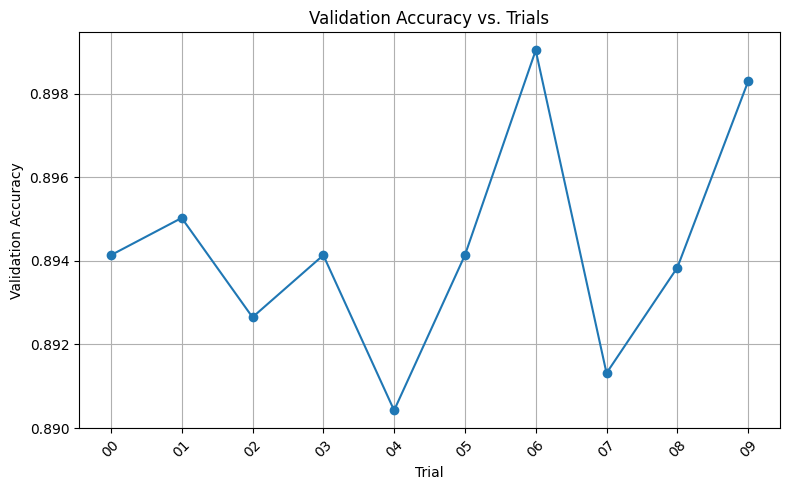

In [ ]:
import matplotlib.pyplot as plt

# Access trials dictionary
trials = tuner.oracle.trials

val_accuracies = []
trial_ids = []

# Loop through trials
for trial_id, trial in trials.items():
    trial_ids.append(trial_id)
    val_acc = trial.metrics.get_last_value("val_accuracy")
    val_accuracies.append(val_acc)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(trial_ids, val_accuracies, marker='o')
plt.xticks(rotation=45)
plt.ylabel("Validation Accuracy")
plt.xlabel("Trial")
plt.title("Validation Accuracy vs. Trials")
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 7 – Final Comparison & Error Analysis


1. **Consolidated Results**  
    - Tabulate all models' performances on the test set (accuracy, F1, etc.)
    - Identify the best-performing model and its hyperparameters.
    

In [ ]:
import pandas as pd
# Example consolidated results
results = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest','XGBoost',"Training FeedForward (Frozen)",'Training FeedForward (Trainable)', 'Simple CNN', 'LSTM'],
    'Accuracy': [0.87, 0.88, 0.88, 0.77, 0.65, 0.89, 0.90, 0.90],
    'F1 Score': [0.89, 0.89, 0.89, 0.82, 0.66, 0.90, 0.90, 0.90]
}
pd.DataFrame(results)


,Model,Accuracy,F1 Score
0,Logistic Regression,0.87,0.89
1,SVM,0.88,0.89
2,Random Forest,0.88,0.89
3,XGBoost,0.77,0.82
4,Training FeedForward (Frozen),0.65,0.66
5,Training FeedForward (Trainable),0.89,0.90
6,Simple CNN,0.90,0.90
7,LSTM,0.90,0.90


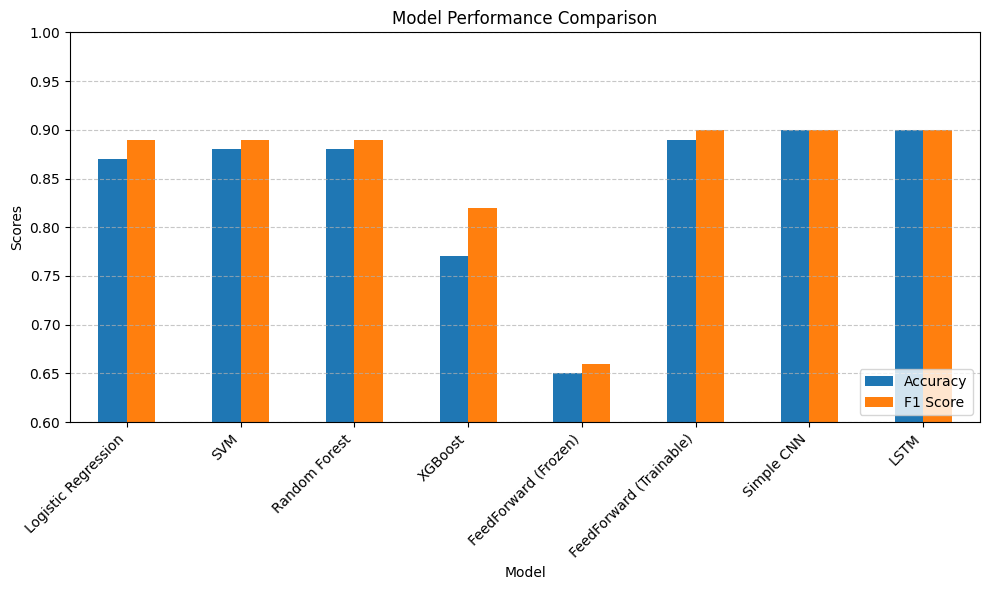

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating the DataFrame
results = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest','XGBoost',
              "FeedForward (Frozen)",'FeedForward (Trainable)', 'Simple CNN', 'LSTM'],
    'Accuracy': [0.87, 0.88, 0.88, 0.77, 0.65, 0.89, 0.90, 0.90],
    'F1 Score': [0.89, 0.89, 0.89, 0.82, 0.66, 0.90, 0.90, 0.90]
}
df_results = pd.DataFrame(results)

# Plotting the graph
fig, ax = plt.subplots(figsize=(10, 6))
df_results.set_index('Model').plot(kind='bar', ax=ax)
plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.6, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


###Best-Performing Model:

Simple CNN and LSTM achieved the highest accuracy and F1-score (both 0.90).

Both models outperform traditional machine learning models (Logistic Regression, SVM, Random Forest, XGBoost) and simpler neural network architectures (FeedForward models).

Given equal performance between CNN and LSTM, the choice depends on computational efficiency and complexity preference:

1. CNN: Faster training. Better at capturing local textual features.
2. LSTM: Better at capturing sequential dependencies and context. Slow to train.

Given the aim of our project is to identify the tone of movies' comments, the LSTM model is a better fit and thus we should choose the Bi-LSTM model for our movie sentiment analysis project, as it offers excellent predictive performance and is capable of capturing context dependent sentiment information effectively.

## Part 8 – Optional Challenge Extensions


1. **Data Augmentation**  
    - Implement data augmentation for text (back-translation, synonym swapping) and measure its impact.
    

In [ ]:
!pip install googletrans==3.1.0a0

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the Stanford Sentiment Treebank v2 (binary classification)
dataset = load_dataset("glue", "sst2")

# Convert to Pandas DataFrame
df = pd.DataFrame(dataset['train'])


In [ ]:
df = df.head(2000) # use 2000 samples out of the whole dataset.
df

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4
...,...,...,...
1995,when there 's nothing else happening,0,1995
1996,on cable,0,1996
1997,"it with ring ,",1,1997
1998,far from a groundbreaking endeavor,0,1998


In [ ]:

# Example for back-translation using a library
from googletrans import Translator

translator = Translator()
df['augmented_review'] = df['sentence'].apply(lambda x: translator.translate(x, src='en', dest='fr').text)
df['augmented_review'] = df['augmented_review'].apply(lambda x: translator.translate(x, src='fr', dest='en').text)
df.head()



,sentence,label,idx,augmented_review
0,hide new secretions from the parental units,0,0,Hide new secretions from parental units
1,"contains no wit , only labored gags",0,1,"does not contain any spirit, only laborious gags"
2,that loves its characters and communicates som...,1,2,who loves his characters and communicates some...
3,remains utterly satisfied to remain the same t...,0,3,remains completely satisfied to stay the same ...
4,on the worst revenge-of-the-nerds clichés the ...,0,4,On the worst pictures of the revenge of the Ne...


In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 1600, Val size: 200, Test size: 200


In [ ]:
preprocessor = TextPreprocessor(rare_word_thresh=2, level="word")

# Preprocess texts
X_train_tok = preprocessor.fit_transform(train_df["sentence"])
X_val_tok = preprocessor.transform(val_df["sentence"])
X_test_tok = preprocessor.transform(test_df["sentence"])

# Labels
y_train = train_df["label"].values
y_val = val_df["label"].values
y_test = test_df["label"].values

# --- TF-IDF ---
tfidf_vectorizer, X_train_tfidf = build_tfidf_vectorizer(X_train_tok)
X_val_tfidf = tfidf_vectorizer.transform([' '.join(t) for t in X_val_tok])
X_test_tfidf = tfidf_vectorizer.transform([' '.join(t) for t in X_test_tok])

# --- Neural Sequences ---
tokenizer = build_tokenizer(X_train_tok)
X_train_pad = get_padded_sequences(tokenizer, X_train_tok)
X_val_pad = get_padded_sequences(tokenizer, X_val_tok)
X_test_pad = get_padded_sequences(tokenizer, X_test_tok)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import pandas as pd

# Logistic Regression (with C tuning)
log_reg = LogisticRegression(max_iter=1000)
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_tfidf, y_train)

# Linear SVM
svm = LinearSVC(C=1.0, max_iter=10000)
svm.fit(X_train_tfidf, y_train)

LinearSVC(max_iter=10000)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_tfidf, y_train)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:18:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Linear SVM': svm,
    'Random Forest': rf,
    'XGBoost': xgb
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred)
    })

df_results = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(df_results)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
3              XGBoost     0.715   0.708661  0.818182  0.759494  0.703535
1           Linear SVM     0.715   0.715447  0.800000  0.755365  0.705556
0  Logistic Regression     0.700   0.704918  0.781818  0.741379  0.690909
2        Random Forest     0.635   0.660870  0.690909  0.675556  0.628788


In [ ]:
preprocessor = TextPreprocessor(rare_word_thresh=2, level="word")

# Preprocess texts
X_train_tok = preprocessor.fit_transform(train_df["augmented_review"])
X_val_tok = preprocessor.transform(val_df["augmented_review"])
X_test_tok = preprocessor.transform(test_df["augmented_review"])

# Labels
y_train = train_df["label"].values
y_val = val_df["label"].values
y_test = test_df["label"].values

# --- TF-IDF ---
tfidf_vectorizer, X_train_tfidf = build_tfidf_vectorizer(X_train_tok)
X_val_tfidf = tfidf_vectorizer.transform([' '.join(t) for t in X_val_tok])
X_test_tfidf = tfidf_vectorizer.transform([' '.join(t) for t in X_test_tok])

# --- Neural Sequences ---
tokenizer = build_tokenizer(X_train_tok)
X_train_pad = get_padded_sequences(tokenizer, X_train_tok)
X_val_pad = get_padded_sequences(tokenizer, X_val_tok)
X_test_pad = get_padded_sequences(tokenizer, X_test_tok)

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_tfidf, y_train)  # Refit with augmented data

# Linear SVM
svm = LinearSVC(C=1.0, max_iter=10000)
svm.fit(X_train_tfidf, y_train)  # Refit with augmented data

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)  # Refit with augmented data

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_tfidf, y_train)  # Refit with augmented data

models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Linear SVM': svm,
    'Random Forest': rf,
    'XGBoost': xgb
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred)
    })

df_results = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(df_results)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:22:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
1           Linear SVM     0.720   0.732759  0.772727  0.752212  0.714141
0  Logistic Regression     0.715   0.726496  0.772727  0.748899  0.708586
3              XGBoost     0.670   0.671875  0.781818  0.722689  0.657576
2        Random Forest     0.655   0.672269  0.727273  0.698690  0.646970


**Before back-translation:**

Top models: XGBoost and Linear SVM, both with accurary 0.715, and F1-socres of apporximately 0.759 and 0.755 respectively.

**After back-translation:**

Improvement Observed: Linear SVM improved from 0.715 to 0.720 in accuracy and slightly reduced F1-score from 0.755 to 0.752, but with improved ROC AUC from 0.7056 to 0.7141.

Logistic Regression showed clear improvement, from 0.700 accuracy to 0.715, and F1-score improved from 0.741 to 0.749, demonstrating clear positive effects.

Decline: XGBoost dropped in accuracy significantly (0.715 to 0.670) and in F1-score (0.759 to 0.722), suggesting that augmentation affected it negatively.

Random Forest showed a modest improvement in accuracy from 0.635 to 0.655 and F1-score from 0.675 to 0.699.



**Overall summary (back-translation):**

Beneficial for simpler models (Logistic Regression and Random Forest), which improved significantly, likely due to their sensitivity to training diversity and lexical variance.

Neutral to mildly beneficial for Linear SVM, showing minor improvements in accuracy and ROC AUC.

Potentially detrimental to complex ensemble methods like XGBoost, possibly due to introducing confusion or noise in subtle feature interactions.

2. **Sentiment Lexicon**  
    - How might integrating sentiment lexicons like VADER improve the sentiment classification model, and what are the challenges of using lexicon-based approaches alongside machine learning models?.
    

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.9 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def extract_vader_features(sentence):
    scores = analyzer.polarity_scores(sentence)
    return scores["pos"], scores["neg"]
df[['pos', 'neg']] = df['sentence'].apply(lambda x: pd.Series(extract_vader_features(x)))
X_train, X_test, y_train, y_test = train_test_split(df[['pos', 'neg']], df['label'], test_size=0.2, random_state=42)

# Train Logistic Regression using sentiment features
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy with VADER features: {accuracy}")
print(f"F1 Score with VADER features: {f1}")

Accuracy with VADER features: 0.7175
F1 Score with VADER features: 0.6954177897574124


**Benefits demonstrated by the results:**

The sentiment lexicon clearly provides useful features that contribute positively to model performance.

It effectively simplifies the sentiment representation, directly guiding the classification task.

**Chanllenges reflected in the results:**

Contextual limitations: The moderate F1 score indicates potential misclassifications due to VADER’s insensitivity to subtle contextual nuances or domain-specific language.

Reliance solely on lexicon features can result in lower model robustness, emphasizing the need to integrate VADER with richer text embeddings or traditional ML features to improve overall classification performance.

---

# Reflecting


**Answer the following inference questions:**



### Part 1 – Data Ingestion & Preprocessing

1. **Data Loading**  
   - How do you ensure that your dataset is properly split into training, validation, and test sets, and why is class balance important during data splitting?

2. **Text Cleaning & Tokenization**  
   - What is the role of tokenization in text preprocessing, and how does it impact the model's performance?



### Part 2 – Exploratory Data Analysis (EDA)

1. **Class Distribution**  
   - How does the class distribution (positive vs negative reviews) impact the model’s performance, and what strategies can be used if the dataset is imbalanced?

2. **Text Characteristics**  
   - What insights can be gained from visualizing word clouds for each sentiment class, and how can it improve feature engineering?


### Part 3 – Baseline Traditional Models

1. **Logistic Regression & SVM**  
   - Why do you use cross-validation when training models like logistic regression or SVM, and how does it help prevent overfitting?

2. **Random Forest & Gradient Boosting**  
   - What role does feature importance play in interpreting Random Forest or XGBoost models?



### Part 4 – Neural Network Models

1. **Simple Feed-Forward**  
   - Why is embedding freezing used when training neural networks on pre-trained embeddings, and how does it affect model performance?

2. **Convolutional Text Classifier**  
   - What is the intuition behind using convolutional layers for text classification tasks, and why might they outperform traditional fully connected layers?


### Part 5 – Transfer Learning & Advanced Architectures

1. **Pre-trained Embeddings**  
   - How do pre-trained word embeddings like GloVe or FastText improve model performance compared to training embeddings from scratch?

2. **Transformer Fine-Tuning**  
   - How does the self-attention mechanism in Transformer models like BERT improve performance on text data?



### Part 6 – Hyperparameter Optimization

1. **Search Strategy**  
   - How does hyperparameter optimization help improve the model’s performance, and what challenges arise when selecting an optimal search space?

2. **Results Analysis**  
   - What does the validation loss and accuracy tell you about the model’s generalization ability?



### Part 7 – Final Comparison & Error Analysis

1. **Consolidated Results**  
   - How do you compare models with different architectures (e.g., logistic regression vs. BERT) to select the best model for deployment?

2. **Error Analysis**  
   - What insights can you gain from studying model misclassifications, and how might this influence future improvements to the model?



### Part 8 – Optional Challenge Extensions

1. **Data Augmentation**  
   - How does back-translation or synonym swapping as text augmentation improve model generalization?

2. **Sentiment Lexicon**  
   - How might integrating sentiment lexicons like VADER improve the sentiment classification model, and what are the challenges of using lexicon-based approaches alongside machine learning models?


#### Part 4

When using pre-trained word embeddings such as FastText or GloVe in a neural network, freezing the embedding layer means keeping its weights constant during training. This is often done to preserve the rich semantic and syntactic relationships that the embeddings have already learned from large-scale corpora. Freezing helps prevent overfitting, especially when working with relatively small or domain-specific datasets like SST-2, where updating the embeddings could cause the model to forget general language patterns in favor of noise. Additionally, it speeds up training by reducing the number of trainable parameters. However, in some cases, allowing the embeddings to be fine-tuned (i.e., unfreezing them) can improve performance by adapting the representations to the specific nuances of the task, though this requires careful regularization to avoid degrading their pre-trained structure.

Convolutional layers are well-suited for text classification tasks because they can effectively capture local patterns in sequences, similar to how they detect visual features in images. In the context of natural language, 1D convolutions act as sliding windows that learn to identify n-gram-like features — such as phrases or word patterns that are strongly correlated with sentiment or topic. For instance, a convolutional filter might learn to activate for phrases like “not good” or “absolutely loved.” These local detectors, combined with pooling layers like global max pooling, allow the model to extract the most salient features from the text regardless of their position. Compared to fully connected layers, CNNs are more efficient and parameter-friendly, making them better at generalizing from limited training data. Their ability to model phrase-level semantics often allows them to outperform simpler feed-forward architectures in tasks like sentiment analysis.


#### Part 5

Pre-trained word embeddings like GloVe and FastText significantly improve model performance by providing rich, dense vector representations of words that capture semantic relationships based on their co-occurrence in large text corpora. Unlike randomly initialized embeddings, which start without any knowledge of language, these pre-trained vectors already encode useful linguistic information such as word similarity, analogy structure (e.g., “king” - “man” + “woman” ≈ “queen”), and even subword information in the case of FastText. This head start allows models to converge faster and generalize better, especially in low-resource settings where the labeled training data may be limited. By leveraging the knowledge embedded in GloVe or FastText, neural models can focus on learning task-specific patterns instead of spending time re-learning basic word semantics from scratch.

The self-attention mechanism in Transformer models like BERT revolutionizes how models process text by allowing them to dynamically focus on different parts of a sentence when encoding each word. Instead of processing text sequentially like RNNs, self-attention evaluates all words in parallel and weighs the relevance of each word to every other word in the sentence. This enables the model to capture long-range dependencies, contextual nuances, and syntactic relationships more effectively. For example, in the sentence “The movie was boring, but the acting was great,” self-attention helps BERT understand that “great” refers to “acting” and not “movie.” By encoding context-aware representations of each word, Transformer models achieve state-of-the-art results in a wide range of NLP tasks, particularly when fine-tuned on domain-specific datasets like SST-2.

#### Part 6
Hyperparameter optimization plays a crucial role in improving a model’s performance by systematically exploring combinations of settings—such as learning rate, number of hidden units, dropout rate, or kernel size—that directly affect how well the model learns. Rather than relying on trial and error or arbitrary defaults, optimization libraries like Keras Tuner or Optuna help identify configurations that balance underfitting and overfitting, ultimately leading to better generalization. However, choosing an optimal search space is challenging: if the range is too narrow, you might miss the best configuration; if it’s too wide, the search becomes inefficient and computationally expensive. Additionally, some hyperparameters interact in complex, non-linear ways, which can make it hard to pinpoint what’s truly driving performance gains. A well-designed search space, guided by domain knowledge and incremental tuning, is critical to achieving meaningful improvements.

Validation loss and accuracy provide key insights into a model’s ability to generalize beyond the training data. A low validation loss combined with high accuracy suggests that the model is learning meaningful patterns and is likely to perform well on unseen examples. However, if validation loss is significantly higher than training loss, or if accuracy stagnates or drops, this may indicate overfitting—where the model has memorized training data but fails to generalize. Conversely, both low training and validation performance may indicate underfitting, meaning the model is too simple or poorly tuned. By monitoring validation metrics during training or hyperparameter tuning, we can assess how well the model captures the task-relevant structure in the data, adjust architecture or regularization, and stop training before overfitting sets in.